# Face Recognition Project

In this project I dabble with face recognition pipeline to deepen my understanding. Come along!



Tasks
- Fine-tune pretrained classifier (vgg, resnet?) with CELoss DONE
- Implement cosine_similarity DONE
- Implement TPR@FPR metric DONE







- Implement distance function for TripleLoss DONE
- Train classificator with TripleLoss

- Implement and train classificator with ArcLoss
- Analyze model performance

- Implement pretrained detection network (yolo/retina? mmdetection/nvidia ssd)
- Implement face alignment (torch landmark tutorial)
- Combine everything above into face-recog pipeline
- ??????
- profit

### Dataset 

I will train out face recognition network on part of the [CelebA dataset](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). but I'll use a version of it that has all the images in it aligned and cropped: https://disk.yandex.ru/d/S8f03spLIA1wrw

Let's look at the data first:

- celebA_imgs — folder with aligned images 
- celebA_anno.txt — file with annotations: which person each image corresponds to
- celebA_train_split.txt — file with train/val/test info

In [1]:
import os
import cv2
import numpy as np
from PIL import Image
from skimage import io, transform

import torch
from torch import nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

from tqdm import tqdm, tqdm_notebook

Let's visualize some images to understand what we're dealing with:

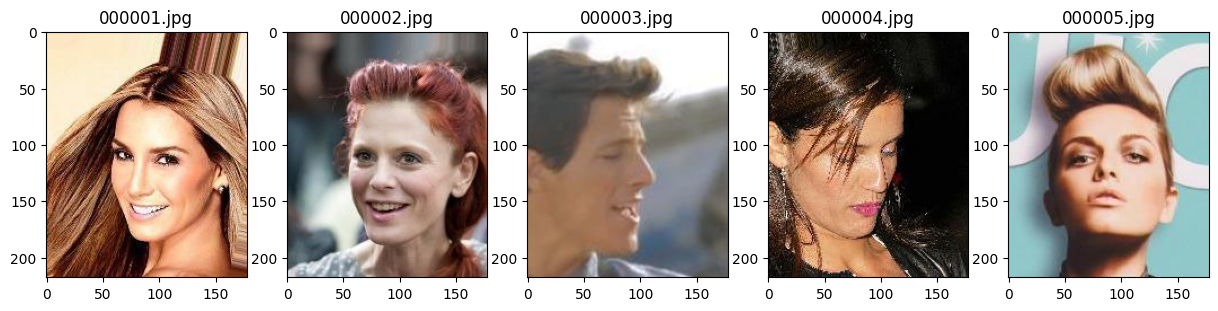

In [2]:
def show_imgs(images_names):
    imgs = []
    for img in images_names:
      img = Image.open(os.path.join('celebA_train_500/celebA_imgs/', img))
      imgs.append(np.array(img))

    f, axes= plt.subplots(1, len(imgs), figsize=(3*len(imgs),5))
    for i, axis in enumerate(axes):
        axes[i].imshow(imgs[i], cmap='gray')
        axes[i].set_title(images_names[i])
    plt.show()

images_names = os.listdir('./celebA_train_500/celebA_imgs/')[:5]
show_imgs(images_names)


### Train Neural Network

Let's build a Datasets and network using this images:

In [3]:
def get_paths(dataset_type='train'):
    '''
    a function that returnes list of images paths for a given type of the dataset
    params:
      dataset_type: one of 'train', 'val', 'test'
    '''

    labels_dict = {
        'train': 0,
        'val': 1,
        'test': 2,
    }

    f = open('celebA_train_500/celebA_train_split.txt', 'r')
    lines = f.readlines()
    f.close()
    lines = [x.strip().split() for x in lines]
    lines = [x[0] for x in lines if int(x[1]) == labels_dict[dataset_type]]

    images_paths = []
    for filename in lines:            
        images_paths.append(os.path.join('celebA_train_500/celebA_imgs/', filename))
    
    return np.array(images_paths)


class celebADataset(Dataset):
    def __init__(self, dataset_type, transform, aug=None, balanced=False):
        self.images = get_paths(dataset_type=dataset_type)
        f = open('celebA_train_500/celebA_anno.txt', 'r')
        labels = f.readlines()
        f.close()
        labels = [x.strip().split() for x in labels]
        labels = {x:y for x, y in labels}
        self.labels = [int(labels[x.split('/')[-1]]) for x in self.images]

        self.transform = transform
        self.aug = aug
        if balanced:
            self._balance_classes()
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):        
        img_name = self.images[idx]
        label = self.labels[idx]
        
        image = Image.open(img_name) 
        
        if self.aug:
            sample = self.aug(
                image=image,
            )
        else:
            sample = {
                'image': image,
                'label': label,
            }
        
        sample['image'] = self.transform(sample['image'])

        return sample
    
    def _balance_classes(self):
        """Rebalances classes distribution by adding extra images for low-frequency
        classes
        """
        data_dict = {}
        for i, item in enumerate(self.labels):
            if item not in data_dict:
                data_dict[item] = []
            data_dict[item].append(self.images[i])
        max_len = max([len(data_dict[x]) for x in data_dict])
        balanced_images, balanced_labels = [], []
        for key in data_dict:
            l = len(data_dict[key])
            if l < max_len:
                data_dict[key] *= max_len // l
                data_dict[key] += data_dict[key][:max_len % l]
            balanced_images += data_dict[key]
            balanced_labels += [key]*max_len
        
        self.labels = balanced_labels
        self.images = balanced_images

In [4]:
transform = transforms.Compose([
      transforms.CenterCrop(150),
      transforms.RandomHorizontalFlip(),
      transforms.Resize(160),
      transforms.ToTensor(),
      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

train_data = celebADataset('train', transform, balanced=True)
val_data = celebADataset('val', transform)
test_data = celebADataset('test', transform)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
#vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

In [ ]:
resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)

In [8]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
for param in resnet.parameters():
    param.requires_grad = False

In [ ]:
resnet.layer3.requires_grad_(True)
resnet.layer4.requires_grad_(True)

In [11]:
class custom_fc(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
        )
        self.classifier = nn.Linear(1024, 500)

    def forward(self, input):
        x = self.fc1(input)
        x = self.fc2(x)
        x = self.classifier(x)
        return x

In [12]:
resnet.fc = custom_fc()

In [ ]:
for param in resnet.parameters():
    print(param.requires_grad)

In [14]:
def fit_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    for batch in train_loader:
        inputs = batch["image"]
        labels = batch["label"]
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        target = F.one_hot(labels, num_classes=500).float()
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [15]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0
    for batch in val_loader:
        inputs = batch["image"]
        labels = batch["label"]
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            target = F.one_hot(labels, num_classes=500).float()
            loss = criterion(outputs, target)
            preds = torch.argmax(outputs, 1)
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = (running_corrects.double() / processed_size).cpu().numpy()
    return val_loss, val_acc

In [16]:
def show_graphs(train, val, max_epochs, title, clear):
  plt.figure(figsize=(20, 10))
  plt.xlim([0, max_epochs])
  plt.plot(train, label="train "+title, color = 'b')
  plt.plot(val, label="val "+title, color = 'y')
  plt.legend(loc='upper right')
  plt.xlabel("epochs")
  plt.ylabel(title)
  plt.title(title+" over epochs")
  display.display(plt.gcf())
  if clear:
    display.clear_output(wait=True)

In [17]:
def train(model, epochs, train_loader, val_loader, optim, criterion, 
          verbose=True, learning_rate=0.001, alpha=1):

    best_model_wts = model.state_dict()
    best_acc = 0.0
    best_epoch = 0
    

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    opt = optim(model.parameters(), lr = learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min',
                                                            patience = 3,
                                                            threshold=0.01,
                                                            verbose = verbose,
                                                            factor  = 0.5)
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=4,
    #                                                      verbose=verbose)
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
        print("loss", train_loss)
        
        val_loss, val_acc = eval_epoch(model, val_loader, criterion)
        history.append((train_loss, train_acc, val_loss, val_acc))

        scheduler.step(val_loss)
        
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()
        
        stats = [item for item in zip(*history)]
        
        if verbose:
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                        v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            #show_graphs(stats[1], stats[3], epochs, 'acc', clear=False)

    return history, best_model_wts, best_epoch, best_acc

In [18]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True)

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam

In [20]:
x = next(iter(train_loader))

In [21]:
x["image"].shape

torch.Size([64, 3, 160, 160])

In [22]:
x["label"].shape

torch.Size([64])

In [23]:
resnet = resnet.to(device)

In [24]:
from IPython import display

In [50]:
torch.cuda.empty_cache()

history, best_model_wts, best_epoch, best_loss = train(resnet, 30, 
                                                       train_loader, 
                                                       val_loader, 
                                                       optimizer,
                                                       criterion,
                                                       verbose=True)

  0%|          | 0/30 [00:00<?, ?it/s]

loss 4.896881281980995


  3%|▎         | 1/30 [00:28<13:53, 28.73s/it]


Epoch 001 train_loss: 4.8969     val_loss 4.3319 train_acc 0.0710 val_acc 0.1051
loss 3.1954392132006193


  7%|▋         | 2/30 [00:54<12:31, 26.84s/it]


Epoch 002 train_loss: 3.1954     val_loss 3.5440 train_acc 0.2548 val_acc 0.2252
loss 2.133242284345348


 10%|█         | 3/30 [01:18<11:37, 25.82s/it]


Epoch 003 train_loss: 2.1332     val_loss 3.0835 train_acc 0.4582 val_acc 0.3405
loss 1.3804706983398973


 13%|█▎        | 4/30 [01:44<11:11, 25.82s/it]


Epoch 004 train_loss: 1.3805     val_loss 2.7697 train_acc 0.6361 val_acc 0.3879
loss 0.8999532673791139


 17%|█▋        | 5/30 [02:13<11:13, 26.94s/it]


Epoch 005 train_loss: 0.9000     val_loss 2.5596 train_acc 0.7547 val_acc 0.4515
loss 0.556593521470912


 20%|██        | 6/30 [02:43<11:14, 28.09s/it]


Epoch 006 train_loss: 0.5566     val_loss 2.6405 train_acc 0.8542 val_acc 0.4628
loss 0.3875704403334891


 23%|██▎       | 7/30 [03:12<10:50, 28.28s/it]


Epoch 007 train_loss: 0.3876     val_loss 2.2390 train_acc 0.8946 val_acc 0.5393
loss 0.2844623635735428


 27%|██▋       | 8/30 [03:40<10:18, 28.11s/it]


Epoch 008 train_loss: 0.2845     val_loss 2.7876 train_acc 0.9214 val_acc 0.4591
loss 0.22079505971823518


 30%|███       | 9/30 [04:07<09:46, 27.92s/it]


Epoch 009 train_loss: 0.2208     val_loss 2.5300 train_acc 0.9361 val_acc 0.5221
loss 0.16499024263599463


 33%|███▎      | 10/30 [04:35<09:17, 27.89s/it]


Epoch 010 train_loss: 0.1650     val_loss 2.3106 train_acc 0.9550 val_acc 0.5577
loss 0.15349211665796259


 37%|███▋      | 11/30 [05:03<08:48, 27.83s/it]

Epoch 00011: reducing learning rate of group 0 to 5.0000e-04.

Epoch 011 train_loss: 0.1535     val_loss 2.4831 train_acc 0.9557 val_acc 0.5296
loss 0.05062077157961869


 40%|████      | 12/30 [05:31<08:20, 27.82s/it]


Epoch 012 train_loss: 0.0506     val_loss 1.8506 train_acc 0.9875 val_acc 0.6492
loss 0.018408543482008908


 43%|████▎     | 13/30 [05:58<07:52, 27.82s/it]


Epoch 013 train_loss: 0.0184     val_loss 1.7815 train_acc 0.9974 val_acc 0.6627
loss 0.011742758757995757


 47%|████▋     | 14/30 [06:26<07:24, 27.77s/it]


Epoch 014 train_loss: 0.0117     val_loss 1.7980 train_acc 0.9981 val_acc 0.6659
loss 0.007021747737828838


 50%|█████     | 15/30 [06:54<06:55, 27.73s/it]


Epoch 015 train_loss: 0.0070     val_loss 1.7243 train_acc 0.9995 val_acc 0.6724
loss 0.005066060218061402


 53%|█████▎    | 16/30 [07:22<06:28, 27.74s/it]


Epoch 016 train_loss: 0.0051     val_loss 1.7350 train_acc 0.9995 val_acc 0.6740
loss 0.004560035576482919


 57%|█████▋    | 17/30 [07:49<06:00, 27.71s/it]


Epoch 017 train_loss: 0.0046     val_loss 1.7036 train_acc 0.9997 val_acc 0.6767
loss 0.003939249095975351


 60%|██████    | 18/30 [08:17<05:32, 27.67s/it]


Epoch 018 train_loss: 0.0039     val_loss 1.7169 train_acc 0.9995 val_acc 0.6740
loss 0.0025372182533733153


 63%|██████▎   | 19/30 [08:44<05:03, 27.61s/it]


Epoch 019 train_loss: 0.0025     val_loss 1.6865 train_acc 1.0000 val_acc 0.6789
loss 0.001902545216814642


 67%|██████▋   | 20/30 [09:12<04:36, 27.65s/it]


Epoch 020 train_loss: 0.0019     val_loss 1.7069 train_acc 1.0000 val_acc 0.6805
loss 0.0018088814624781279


 70%|███████   | 21/30 [09:40<04:09, 27.69s/it]


Epoch 021 train_loss: 0.0018     val_loss 1.7326 train_acc 0.9999 val_acc 0.6837
loss 0.0013681723690613537


 73%|███████▎  | 22/30 [10:07<03:41, 27.65s/it]


Epoch 022 train_loss: 0.0014     val_loss 1.6970 train_acc 1.0000 val_acc 0.6778
loss 0.0012515570303937148


 77%|███████▋  | 23/30 [10:35<03:13, 27.66s/it]

Epoch 00023: reducing learning rate of group 0 to 2.5000e-04.

Epoch 023 train_loss: 0.0013     val_loss 1.6841 train_acc 1.0000 val_acc 0.6864
loss 0.0011625918338472863


 80%|████████  | 24/30 [11:03<02:46, 27.81s/it]


Epoch 024 train_loss: 0.0012     val_loss 1.6912 train_acc 1.0000 val_acc 0.6794
loss 0.0010643775747783961


 83%|████████▎ | 25/30 [11:32<02:20, 28.12s/it]


Epoch 025 train_loss: 0.0011     val_loss 1.6721 train_acc 1.0000 val_acc 0.6848
loss 0.0008725592036314897


 87%|████████▋ | 26/30 [11:59<01:51, 27.85s/it]


Epoch 026 train_loss: 0.0009     val_loss 1.6799 train_acc 1.0000 val_acc 0.6880
loss 0.0009495022530362489


 90%|█████████ | 27/30 [12:28<01:24, 28.08s/it]

Epoch 00027: reducing learning rate of group 0 to 1.2500e-04.

Epoch 027 train_loss: 0.0009     val_loss 1.7018 train_acc 1.0000 val_acc 0.6794
loss 0.0007837269288740987


 93%|█████████▎| 28/30 [12:53<00:54, 27.29s/it]


Epoch 028 train_loss: 0.0008     val_loss 1.7126 train_acc 1.0000 val_acc 0.6816
loss 0.0008014911812613037


 97%|█████████▋| 29/30 [13:22<00:27, 27.70s/it]


Epoch 029 train_loss: 0.0008     val_loss 1.6757 train_acc 1.0000 val_acc 0.6853
loss 0.0008000413562465263


100%|██████████| 30/30 [13:50<00:00, 27.69s/it]


Epoch 030 train_loss: 0.0008     val_loss 1.6668 train_acc 1.0000 val_acc 0.6886


In [53]:
torch.save(resnet.state_dict(), "best_wts")

In [25]:
resnet.load_state_dict(torch.load("best_wts"))

<All keys matched successfully>

Code for model evaluating:

In [26]:
def evaluate(model, dataloader, loss_fn):
    
    losses = []

    num_correct = 0
    num_elements = 0

    for i, batch in enumerate(dataloader):
        
        X_batch, y_batch = batch['image'], batch['label']
        num_elements += len(y_batch)
        
        with torch.no_grad():
            logits = model(X_batch.to(device))
            
            loss = loss_fn(logits, F.one_hot(y_batch.to(device), num_classes=500).float())
            losses.append(loss.item())
            
            y_pred = torch.argmax(logits, dim=1)
            
            num_correct += torch.sum(y_pred.cpu() == y_batch)
    
    accuracy = num_correct / num_elements
            
    return accuracy.numpy(), np.mean(losses)

In [27]:
test_accuracy, test_loss = evaluate(resnet, test_loader, criterion)
test_accuracy, test_loss

(array(0.60091144, dtype=float32), 2.3352678765853248)

**Cosine similarity calculation**: now let's drop the last layer of trained network. Then let's try getting embeddings for some images from train set and for images from test set. It's useful to calculate cosine similarities between embeddings corresponding to the pictures of the same person and different people.

In [28]:
resnet.fc.classifier = nn.Identity()

In [29]:
class SoloCelebADataset(celebADataset):
    """Creates dataset for a specific label"""
    def __init__(self, dataset_type, transform, aug=None, balanced=False, label = None):
        super().__init__(dataset_type, transform, aug, balanced)
        labels_indices = self._find_indices(self.labels, label)
        self.images = [self.images[i] for i in labels_indices]
        self.labels = [self.labels[i] for i in labels_indices]

    
    def _find_indices(self, lst, label):
        return [i for i, elem in enumerate(lst) if elem == label]
    

In [30]:
zero_train_data = SoloCelebADataset("train", transform, label=3)

In [31]:
zero_train_loader = torch.utils.data.DataLoader(zero_train_data, 
                                                batch_size=10, 
                                                shuffle=True, drop_last=True)

In [32]:
zero_batch = next(iter(zero_train_loader))["image"].to(device)

In [33]:
resnet.eval()
zero_outputs = resnet(zero_batch)

In [34]:
from torch import linalg as LA

In [35]:
def cosine_similarity(a, b):
    a = a.float()
    b = b.float()
    nomimator = torch.dot(a, b)
    denominator = LA.norm(a)*LA.norm(b)
    eps = 1e-10
    return (nomimator/(denominator + eps)).item()

In [36]:
def cosine_between_same(embeddings):
    res = []
    l = len(embeddings)
    for i in range(l):
        for k in range(i+1, l):
            res.append(cosine_similarity(embeddings[i], embeddings[k]))
    return res

In [37]:
zero_list = cosine_between_same(zero_outputs)

In [38]:
one_train_data = SoloCelebADataset("test", transform, label=3)
one_train_loader = torch.utils.data.DataLoader(one_train_data, 
                                                batch_size=3, 
                                                shuffle=True, drop_last=True)
one_batch = next(iter(one_train_loader))["image"].to(device)
resnet.eval()
one_outputs = resnet(one_batch)

In [39]:
def cosine_between_different(first, second):
    res = []
    for a in first:
        for b in second:
            res.append(cosine_similarity(a, b))
    return res

In [40]:
zero_one_list = cosine_between_different(zero_outputs, one_outputs)

In [41]:
sum(zero_list)/len(zero_list)

0.636827744377984

In [42]:
sum(zero_one_list)/len(zero_one_list)

0.48805145571629205

As we see, cosine similarity between different faces' embeddings is significantly less then one between same faces.

## Identificaton rate metric

Let's calculate another metric for the model: **identification rate**. This is how it works:

We have two sets of faces: query and distractors. None of the faces from those sets are present in train, val or test sets. To implement the metric one should complete following steps:

1. calculate cosine similarities between all the faces corresponding to the same people from query dataset.
2. calculate cosine similarities between all the faces corresponding to the different people from query dataset. 
3. calculate cosine similarities between all the pairs of embeddings corresponding to query and distractors. 
4. Sum numbers of similarities from 2 and 3 stages. This is a number of false pairs.
5. fix **FPR** (false positive rate). Let it be 0.01 in our case. FPR multiplied by a number of false pairs from the stage 4 is the number of false positives we would allow our model to make. Let's call this number N
6. Sort all the similarities of false pairs by descending order. Get the Nth element from the beginning — that's our **threshold similarity**.
7. Calculate how many positive similarities from stage 1 are equal or more that threshold. Divide this number by whole number of positive similarities from stage 1. This is TPR (true positive rate) — our metric.

This metric can also be expressed as TPR@FPR=0.01. Let's get to work!

In [43]:
from collections import defaultdict

# file with query part annotations: which image belongs to which class
# format: 
#     image_name_1.jpg 2678
#     image_name_2.jpg 2679
f = open('./celebA_ir/celebA_anno_query.csv', 'r')
query_lines = f.readlines()[1:]
f.close()
query_lines = [x.strip().split(',') for x in query_lines]
# plain list of image names from query. Neede to compute embeddings for query
query_img_names = [x[0] for x in query_lines]

# dictionary with info of which images from query belong to which class
# format:
#     {class: [image_1, image_2, ...]}
query_dict = defaultdict(list)
for img_name, img_class in query_lines:
  query_dict[img_class].append(img_name)

# list of distractor images
distractors_img_names = os.listdir('./celebA_ir/celebA_distractors') 

In [44]:
basic_transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [45]:
query_path = "celebA_ir/celebA_query/"
distractors_path = "celebA_ir/celebA_distractors/"

In [46]:
def path2tensor(path, transform=basic_transform):
    image = Image.open(path)
    image = transform(image)
    image.to(device)
    image = image.to(device)
    return image.unsqueeze(0)

In [47]:
def compute_embeddings(model, images_list, minibatch=64):
  '''
  compute embeddings from the trained model for list of images.
  params:
    model: trained nn model that takes images and outputs embeddings
    images_list: list of images paths to compute embeddings for
  output:
    list: list of model embeddings. Each embedding corresponds to images 
          names from images_list
  '''
  model.eval()
  images_list = [path2tensor(x) for x in images_list]
  batch = torch.cat(images_list)

  top, bottom = 0, minibatch
  res = []
  
  for i in range(0, len(batch), minibatch):
    if top > len(batch):
      top = len(batch) - 1

    output = model(batch[top:bottom]).cpu()
    res += [x for x in output]
    top += minibatch
    bottom += minibatch

    if top == len(batch) - 1:
      break

  return res

In [48]:
full_query_img_names = [query_path + x for x in query_img_names]
full_distractors_img_names = [distractors_path + x for x in distractors_img_names]

In [49]:
path2tensor(full_query_img_names[0]).get_device()

0

In [50]:
query_embeddings = compute_embeddings(resnet, full_query_img_names)
distractors_embeddings = compute_embeddings(resnet, full_distractors_img_names)

In [51]:
def get_label_embeddings(query_dict, query_img_names, query_embeddings, label):
    label_images = query_dict[label]
    indices = [i for i, item in enumerate(query_img_names) if item in label_images]
    label_embeddings = [query_embeddings[i] for i in indices]
    return label_embeddings

def compute_cosine_query_pos(query_dict, query_img_names, query_embeddings):
  '''
  compute cosine similarities between positive pairs from query (stage 1)
  params:
    query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in 
                the dataset. Value: images corresponding to that class
    query_img_names: list of images names
    query_embeddings: list of embeddings corresponding to query_img_names
  output:
    list of floats: similarities between embeddings corresponding 
                    to the same people from query list
  '''
  res = []

  for label in query_dict:
    label_embeddings = get_label_embeddings(query_dict, query_img_names, 
                                            query_embeddings, label)
    
    res += cosine_between_same(label_embeddings)
  return res

  

def compute_cosine_query_neg(query_dict, query_img_names, query_embeddings):
  '''
  compute cosine similarities between negative pairs from query (stage 2)
  params:
    query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in 
                the dataset. Value: images corresponding to that class
    query_img_names: list of images names
    query_embeddings: list of embeddings corresponding to query_img_names
  output:
    list of floats: similarities between embeddings corresponding 
                    to different people from query list
  '''
  res = []
  labels_list = list(query_dict.keys())

  for i, first_label in enumerate(labels_list):
    for second_label in labels_list[i+1:]:
     first_label_embeddings = get_label_embeddings(query_dict, query_img_names, 
                                            query_embeddings, first_label)
     second_label_embeddings = get_label_embeddings(query_dict, query_img_names, 
                                            query_embeddings, second_label)
     res += cosine_between_different(first_label_embeddings, second_label_embeddings)

  return res



In [52]:
def compute_cosine_query_distractors(query_embeddings, distractors_embeddings):
  '''
  compute cosine similarities between negative pairs from query and distractors
  (stage 3)
  params:
    query_embeddings: list of embeddings corresponding to query_img_names
    distractors_embeddings: list of embeddings corresponding to distractors_img_names
  output:
    list of floats: similarities between pairs of people (q, d), where q is 
                    embedding corresponding to photo from query, d —
                    embedding corresponding to photo from distractors
  '''
  return cosine_between_different(query_embeddings, distractors_embeddings)

In [53]:
cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names, 
                                            query_embeddings)
cosine_query_neg = compute_cosine_query_neg(query_dict, query_img_names, 
                                            query_embeddings)
cosine_query_distractors = compute_cosine_query_distractors(query_embeddings, 
                                                            distractors_embeddings)


Let's check our code with simple examples:

In [58]:
test_query_dict = {
    2876: ['1.jpg', '2.jpg', '3.jpg'],
    5674: ['5.jpg'],
    864:  ['9.jpg', '10.jpg'],
}
test_query_img_names = ['1.jpg', '2.jpg', '3.jpg', '5.jpg', '9.jpg', '10.jpg']
test_query_embeddings = [
                    [1.56, 6.45,  -7.68],
                    [-1.1 , 6.11,  -3.0],
                    [-0.06,-0.98,-1.29],
                    [8.56, 1.45,  1.11],
                    [0.7,  1.1,   -7.56],
                    [0.05, 0.9,   -2.56],
]

test_distractors_img_names = ['11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg']

test_distractors_embeddings = [
                    [0.12, -3.23, -5.55],
                    [-1,   -0.01, 1.22],
                    [0.06, -0.23, 1.34],
                    [-6.6, 1.45,  -1.45],
                    [0.89,  1.98, 1.45],
]

test_cosine_query_pos = compute_cosine_query_pos(test_query_dict, test_query_img_names, 
                                            torch.tensor(test_query_embeddings))
test_cosine_query_neg = compute_cosine_query_neg(test_query_dict, test_query_img_names, 
                                            torch.tensor(test_query_embeddings))
test_cosine_query_distractors = compute_cosine_query_distractors(torch.tensor(test_query_embeddings), 
                                                            torch.tensor(test_distractors_embeddings))

In [59]:
true_cosine_query_pos = [0.8678237233650096, 0.21226104378511604,
                         -0.18355866977496182, 0.9787437979250561]
assert np.allclose(sorted(test_cosine_query_pos), sorted(true_cosine_query_pos)), \
      "A mistake in compute_cosine_query_pos function"

In [60]:
true_cosine_query_neg = [0.15963231223161822, 0.8507997093616965, 0.9272761484302097,
                         -0.0643994061127092, 0.5412660901220571, 0.701307100338029,
                         -0.2372575528216902, 0.6941032794522218, 0.549425446066643,
                         -0.011982733001947084, -0.0466679194884999]
assert np.allclose(sorted(test_cosine_query_neg), sorted(true_cosine_query_neg)), \
      "A mistake in compute_cosine_query_neg function"


In [61]:

true_cosine_query_distractors = [0.3371426578637511, -0.6866465610863652, -0.8456563512871669,
                                 0.14530087113136106, 0.11410510307646118, -0.07265097629002357,
                                 -0.24097699660707042,-0.5851992679925766, 0.4295494455718534,
                                 0.37604478596058194, 0.9909483738948858, -0.5881093317868022,
                                 -0.6829712976642919, 0.07546364489032083, -0.9130970963915521,
                                 -0.17463101988684684, -0.5229363015558941, 0.1399896725311533,
                                 -0.9258034013399499, 0.5295114163723346, 0.7811585442749943,
                                 -0.8208760031249596, -0.9905139680301821, 0.14969764653247228,
                                 -0.40749654525418444, 0.648660814944824, -0.7432584300096284,
                                 -0.9839696492435877, 0.2498741082804709, -0.2661183373780491]
assert np.allclose(sorted(test_cosine_query_distractors), sorted(true_cosine_query_distractors)), \
      "A mistake in compute_cosine_query_distractors function"

Now we implement the final function: identification rate calculation

In [62]:
def compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors, 
               fpr=0.1):
  '''
  compute identification rate using precomputed cosine similarities between pairs
  at given fpr
  params:
    cosine_query_pos: cosine similarities between positive pairs from query
    cosine_query_neg: cosine similarities between negative pairs from query
    cosine_query_distractors: cosine similarities between negative pairs 
                              from query and distractors
    fpr: false positive rate at which to compute TPR
  output: 
    float: threshold for given fpr 
    float: TPR at given FPR
  '''
  false_pairs = cosine_query_neg+cosine_query_distractors
  N = round(fpr*len(false_pairs))
  threshold = sorted(false_pairs, reverse=True)[N]
  ge_threshold = [x for x in cosine_query_pos if x >= threshold]
  tpr_at_fpr = len(ge_threshold)/len(cosine_query_pos)

  return threshold, tpr_at_fpr

Testing...

In [63]:
test_thr = []
test_tpr = []
for fpr in [0.5, 0.3, 0.1]:
  x, y = compute_ir(test_cosine_query_pos, test_cosine_query_neg, 
                    test_cosine_query_distractors, fpr=fpr)
  test_thr.append(x)
  test_tpr.append(y)

In [64]:
true_thr = [-0.011982733001947084, 0.3371426578637511, 0.701307100338029]
assert np.allclose(np.array(test_thr), np.array(true_thr)), "A mistake in computing threshold"

true_tpr = [0.75, 0.5, 0.5]
assert np.allclose(np.array(test_tpr), np.array(true_tpr)), "A mistake in computing tpr"

Finally compute tpr for faces query and distractors dataset and different fpr. this will allow us to plot the ROC curve.

In [75]:
tpr = []
fpr = np.linspace(0, 1, 100, endpoint=False)

In [76]:
for item in fpr:
    tpr.append(compute_ir(cosine_query_pos, cosine_query_neg, 
                    cosine_query_distractors, fpr=item)[1])

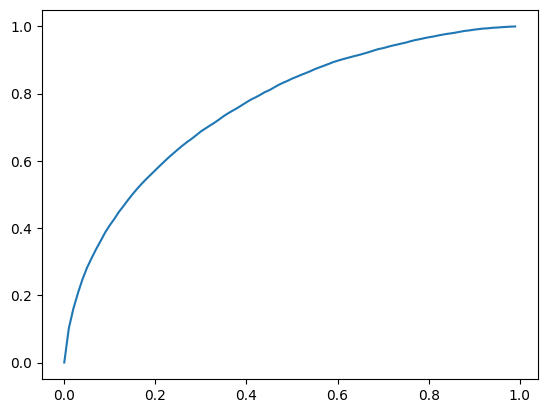

In [77]:
plt.plot(fpr, tpr)

Neat! Not perfect, but we'll work on it. Specifically, we will train our ResNet classificator with more effective loss functions:

## Advanced loss functions

### TripletLoss

The core idea of TripleLoss is to make embeddings of the same people more close, compact in the embedding space, and the embeddings of the different people be more separate. Formula for the loss:

$$L(e, p, n) = max\{d(a, p) - d(a, n) + margin, 0\},$$

where 
- $e$ is embedding of a photo (output of a model)
- $p$ is a positive embedding for the photo (embedding that we want $e$ be close to)
- $n$ is a negative embedding for the photo (embedding that we want $e$ be far from)
- $d(x, y)$ is a distance measure between embeddings 
- margin — a positive margin to further boost the difference between $d(a, p)$ and $d(a, n)$



Let's think of what the distance function $d$ should be in our case: cosine similarity is not a distance measure — the more cosine similarity, the closer embeddings are. We'll use cosine distance instead: c_distance = 1 - c_similarity. Furthermore, to ensure that a lower distance value implies more similarity, we can take the square root of the distance:

In [ ]:
def modified_cosine_distance(a, b):
    cos_sim = cosine_similarity(a, b)
    cos_dist = 1.0 - cos_sim
    mod_cos_dist = np.sqrt(cos_dist)
    return mod_cos_dist

In [ ]:
triplet_loss_fn = nn.TripletMarginWithDistanceLoss(
    distance_function=modified_cosine_distance, margin=1.0, swap=False, reduction='mean')